In [1]:
import covasim as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import json
from scipy.optimize import minimize


Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


The simulation will take place between start_day and end_day. covasim can not support simulations longer thanb 150 days

In [2]:
start_day = '2020-03-02'
end_day   = '2020-07-01'
date_range = pd.date_range(start=start_day, end=end_day, freq='D')
all_days = cv.date_range(start_day, end_day)
beta_initial=0.015

We use Gerlee et al. to have a moving beta according to the data from the traffic. 

In [3]:
# defining a moving beta accoding to the article predicting regional covid 19 hospital admissions in Sweden using mobility data

mobility='''0
-0,0436877025562212
-0,142183890633573
-0,414264196497882
-0,490226517606742
-0,520691444229291
-0,601104998394856
-0,565468289968282
-0,500887028474234
-0,533539503417897
-0,489363271950639
-0,479732407975015
-0,525650201055078
-0,4254
-0,4325
-0,394
-0,53
-0,47
-0,5
-0,53
-0,56
-0,55
-0,53
-0,5
-0,47
-0,39
-0,35
-0,34
-0,34
-0,33
-0,33
-0,32
-0,31
-0,32
-0,31
-0,42
-0,41
-0,43
-0,45
-0,44
-0,44
-0,51
-0,51
-0,66
-0,77
'''.replace(',','.').split('\n')


floatmobility = [float(i) for i in mobility if i != '']
betas = [ 4.11 + 6.68 * mob for mob in floatmobility]
betas_by_week=np.array([betas[i//7] for i in range(len(all_days))])
# coeff_betas=[betas_by_week[i+1]/betas_by_week[i] for i in range(len(betas_by_week)-1)]
coeff_betas=[betas_by_week[i]/beta_initial for i in range(len(betas_by_week))]


The values of beta seem very high compared to the previsous values found in litrerature. 


Creating parameters that fit the Swedish population

In [4]:
parameters_sweden=dict(pop_size=1000000,  #  10 368 969 is population in Sweden in 2019 according to https://www.worldometers.info/ 
                                             # 1608037 is the population in Stockholm in 2019 according to https://worldpopulationreview.com/

                            start_day = start_day,
                            end_day   = end_day,
                            pop_type = 'hybrid',
                            beta=beta_initial,  
                            location = 'Sweden',
                            pop_infected = 20, #value by default, TOCHANGE
                            
                            )




In [5]:
# interventions of changing beta: we create a cv.change_beta object that changes beta everyday according to the values of the traffic circulation. 
cb_mobility = cv.change_beta(days=all_days, changes=coeff_betas, do_plot=False) # warning, change_beta does not change the value of beta, it multiplies the value of beta_0 by a constant and replaces the previois beta by this new one. 


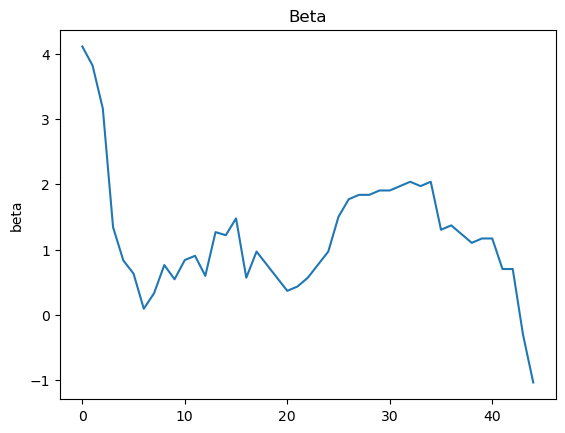

In [6]:
plt.plot(np.array(betas))
plt.title('Beta')
plt.ylabel('beta')
plt.show()


In [7]:
# set run_simul = True to run the simulation and create data : 
run_simul=False
if run_simul: 
    my_simulation_sweden_interventions=cv.Sim(parameters_sweden, interventions=cb_mobility)
    my_simulation_sweden_interventions.run()
    my_simulation_sweden_interventions.plot([ 'new_infections', 'cum_infections', 'new_deaths', 'cum_deaths'])


We have stored in a csv file the synthetized data and extract it as a baseline: 

In [8]:
df = pd.read_csv('deaths_and_infections.csv')
# remove a columns from a df: 
df.drop(columns=['Unnamed: 0'], inplace=True)

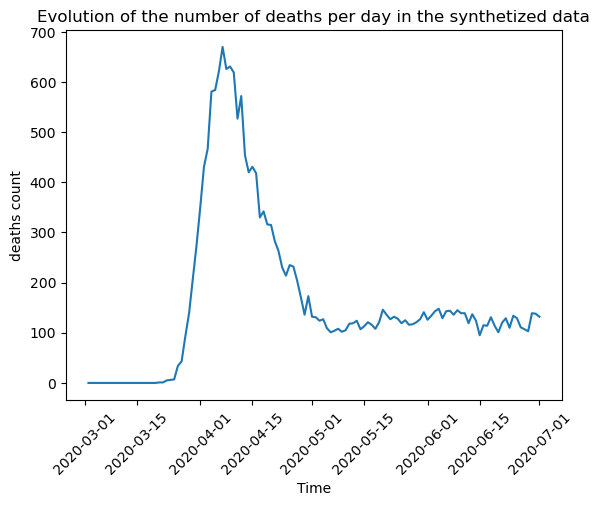

In [9]:
plt.plot(date_range, df['new_deaths'], label='new_deaths')
plt.title('Evolution of the number of deaths per day in the synthetized data')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('deaths count')

plt.show()

In [10]:
new_deaths=np.array(df['new_deaths'])
death_cumul=np.array([sum(new_deaths[:i]) for i in range(len(new_deaths))])
dates_of_pandemic=np.arange(len(new_deaths))

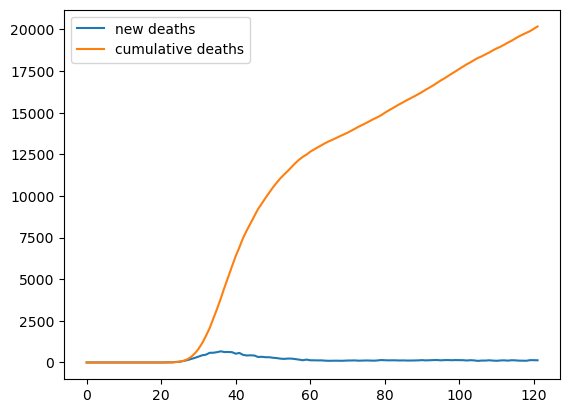

In [11]:
plt.plot(dates_of_pandemic,new_deaths, label='new deaths')
plt.plot(dates_of_pandemic,death_cumul, label='cumulative deaths')
plt.legend()
plt.show()

We try to fit some simple models

In [12]:
def exponential_func(x, a, b, c):
    return a*np.exp(b*x)+c

In [13]:
def polynomla_func(x, a, b, c, d, e , f):
    return a*x**2+b*x+c + e*x**3 

In [14]:
p, _ =curve_fit(exponential_func, dates_of_pandemic, new_deaths)
p
p2, _ =curve_fit(polynomla_func, dates_of_pandemic, new_deaths)


c:\Users\grego\Miniconda3\envs\env_qcm\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


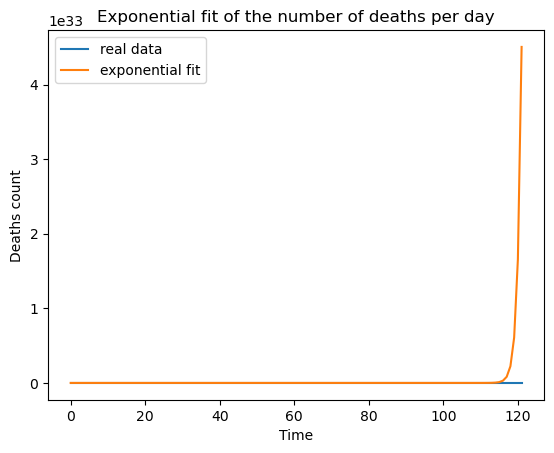

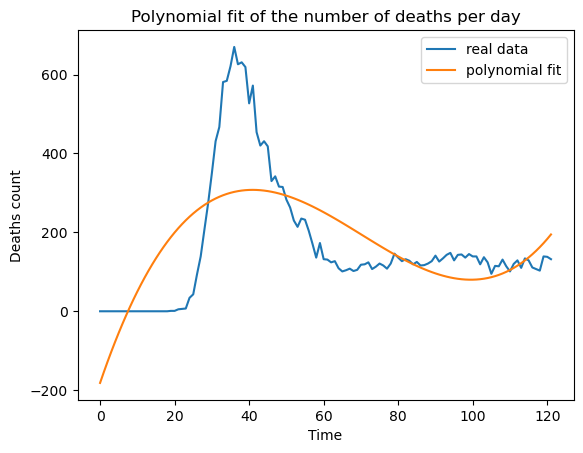

In [15]:
plt.plot(dates_of_pandemic,new_deaths, label='real data')
plt.plot(dates_of_pandemic, exponential_func(dates_of_pandemic, *p), label= 'exponential fit')
plt.title('Exponential fit of the number of deaths per day')
plt.xlabel('Time')
plt.ylabel('Deaths count')

plt.legend()
plt.show()

plt.plot(dates_of_pandemic,new_deaths,  label='real data')
plt.plot(dates_of_pandemic, polynomla_func(dates_of_pandemic, *p2), label= 'polynomial fit')
plt.title('Polynomial fit of the number of deaths per day')
plt.xlabel('Time')
plt.ylabel('Deaths count')

plt.legend()
plt.show()


